# ARTIST Tutorial: Heliostat Raytracing
This tutorial provides a brief introduction to ARTIST showcasing how Heliostat Raytracing is performed. The tutorial will run through some basic concepts necessary to understanding ARTIST including:
- How to load a scenario.
- Understanding what information is contained in an ARTIST scenario file.
- Activating the kinematic in a heliostat to align this heliostat for raytracing.
- Performing heliostat raytracing to generate a flux density image on the receiver.

## Setup
Before we go through our tutorial we need to setup ARTIST. The first step in this setupt is to install the ARTIST package from GitHub!

In [1]:
!pip install https://github.com/ARTIST-Association/ARTIST

  ERROR: HTTP error 404 while getting https://github.com/ARTIST-Association/ARTIST
ERROR: Could not install requirement https://github.com/ARTIST-Association/ARTIST because of HTTP error 404 Client Error: Not Found for url: https://github.com/ARTIST-Association/ARTIST for URL https://github.com/ARTIST-Association/ARTIST


The second step is to import all the packages required for our tutorial:

In [2]:
import torch
import h5py
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import tight_layout
from typing import Optional, List

from artist.scenario import Scenario
from artist.raytracing.heliostat_tracing import HeliostatRayTracer

The final step involves downloading the **Scenario** HDF5 file. ARTIST uses a Hierarchical Data Format (HDF5) file to store cruicial scenario information, such as the number of heliostats, the location of these heliostats, the type of receiver used and the model implemented for the light source. We will explore the contents of the scenario later, but for now we need to download the scenario file from an external source so that we can load it into ARTIST. We achieve this using the ``wget`` command below.

In [3]:
url = "https://drive.google.com/uc?export=download&id=1WSJyabylkK8cMDgulymVP5nPNGNf_BzN"
!wget -O tutorial_scenario.h5 "$url"

--2024-05-23 16:02:37--  https://drive.google.com/uc?export=download&id=1WSJyabylkK8cMDgulymVP5nPNGNf_BzN
Resolving drive.google.com (drive.google.com)... 2a00:1450:4001:810::200e, 142.250.185.142
Connecting to drive.google.com (drive.google.com)|2a00:1450:4001:810::200e|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1WSJyabylkK8cMDgulymVP5nPNGNf_BzN&export=download [following]
--2024-05-23 16:02:38--  https://drive.usercontent.google.com/download?id=1WSJyabylkK8cMDgulymVP5nPNGNf_BzN&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 2a00:1450:4001:802::2001, 142.250.185.97
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|2a00:1450:4001:802::2001|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64624 (63K) [application/octet-stream]
Saving to: ‘tutorial_scenario.h5’

tutorial_scenario.h 100%[===================>]  6

Executing this command has saved a file ``tutorial_scenario.h5`` in our current working directory and we can use this in the next step to load a scenario in ARTIST! 

## Scenarios in ARTIST
ARTIST is based on **Scenarios** which are loaded as **HDF5** files. These scenarios have a specific structure which is listed below (don't worry, we will explain it in more detail in a second, just keep scrolling for now):
```
   .
├── receivers [1,*]
│   ├── receiver1
│   │   ├── type [1,1] # e.g. planar
│   │   ├── position_center [1,1]
│   │   ├── curvature_e [0,1]
│   │   ├── curvature_u [0,1]
│   │   ├── normal_vector [1,1]
│   │   ├── plane_e [1,1]
│   │   ├── plane_u [1,1]
│   │   ├── resolution_e [1,1]
│   │   └── resolution_u [1,1]
│   ├── receiver2
│   │   └── ...
│   └── ...
├── lightsources [1,*]
│   ├── lightsource1
│   │   ├── type [1,1]
│   │   ├── number_of_rays [1,1]
│   │   └── distribution_parameters [1,1]
│   │       ├── distribution_type [1,1]
│   │       ├── mean [0,1]
│   │       ├── variance [0,1]
│   │       └── ...
│   ├── lightsource2
│   │   └── ...
│   └── ...
├── heliostats [1,*]
│   ├── heliostat1
│   │   ├── id [1,1]
│   │   ├── position [1,1]
│   │   ├── aim_point [1,1]
│   │   ├── surface [0,1]
│   │   │   └── facets [1,*]
│   │   │       ├── facet1
│   │   │       │   ├── control_points [1,1]
│   │   │       │   ├── degree_e [1,1]
│   │   │       │   ├── degree_n [1,1]
│   │   │       │   ├── number_of_eval_points_e [1,1]
│   │   │       │   ├── number_of_eval_points_n [1,1]
│   │   │       │   ├── width [1,1]
│   │   │       │   ├── height [1,1]
│   │   │       │   ├── position [1,1]
│   │   │       │   ├── canting_e [1,1]
│   │   │       │   └── canting_n [1,1]
│   │   │       ├── facet2
│   │   │       │   └── ...
│   │   │       └── ...
│   │   ├── kinematic [0,1]
│   │   │   ├── type [1,1]
│   │   │   ├── offsets [0,3]
│   │   │   │   ├── offset_e
│   │   │   │   ├── offset_n
│   │   │   │   └── offset_u
│   │   │   └── deviations [0,*]
│   │   │       ├── first_joint_translation [0,1]
│   │   │       ├── first_joint_tilt_e [0,1]
│   │   │       └── ...
│   │   └── actuators [0,*]
│   │       ├── actuator1
│   │       │   ├── type [1,1]
│   │       │   └── parameters [0,*]
│   │       │       ├── first_joint_increment [0,1]
│   │       │       ├── first_joint_radius [0,1]
│   │       │       └── ...
│   │       └── actuator2
│   │           └── ...
│   ├── heliostat2
│   │   └── ...
│   └── ...
└── prototypes [1,1]
    ├── surface [1,1]
    │   └── facets [1,*]
    │       ├── facet1
    │       │   ├── control_points [1,1]
    │       │   ├── degree_e [1,1]
    │       │   ├── degree_n [1,1]
    │       │   ├── number_of_eval_points_e [1,1]
    │       │   ├── number_of_eval_points_n [1,1]
    │       │   ├── width [1,1]
    │       │   ├── height [1,1]
    │       │   ├── position [1,1]
    │       │   ├── canting_e [1,1]
    │       │   └── canting_n [1,1]
    │       ├── facet2
    │       │   └── ...
    │       └── ...
    ├── kinematic [1,1]
    │   ├── type [1,1]
    │   ├── offsets [0,3]
    │   │   ├── offset_e
    │   │   ├── offset_n
    │   │   └── offset_u
    │   └── deviations [0,*]
    │       ├── first_joint_translation [0,1]
    │       ├── first_joint_tilt_e [0,1]
    │       └── ...
    └── actuators [1,*]
        ├── actuator1
        │   ├── type [1,1]
        │   └── parameters [0,*]
        │       ├── first_joint_increment [0,1]
        │       ├── first_joint_radius [0,1]
        │       └── ...
        └── actuator2
            └── ...
```
Whilst this scenario structure seems complicated, the key elements are quite simple:
   - **Receivers:** Every scenario in ARTIST contains at least one receiver. The receiver is the object where the light is concentrated and resulting heat energy used to generate electricity or for industrial processes. A ``Receiver`` object contains information such as the position, the type, whether the receiver is curved or not etc. Since large Concentrating Solar Power Plants (CSPs) may contain multiple receiver, ARTIST is modelled on a scenario structure that also allows multiple receiver - however currently the code in development only supports a single receiver.

   - **Light Sources:** An ARTIST scenario also contains at least one light source. A light source models how the light is generated, which is eventually reflected onto a receiver. A light source must have a type, for example, a ``Sun``, and defines how many rays are to be sampled from this light source for raytracing. Since it may be interesting to model multiple light sources for calibration purposes, the ARTIST scenario structure also supports more than one light source. However, currently we only consider scenarios with one light source.

   - **Heliostats:** A CSP relies on mirrors, so-called *heliostats* to reflect the light on to the receiver. Therefore, an ARTIST scenario must contain at least one (and usually multiple) heliostats. As well as a unique ID, a position, and the aim point the heliostat is focusing on, a heliostat requires a *surface*, a *kinematic*, and at least one *actuator*. The surface is the reflective surface of the heliostat and is made up of multiple *facets*. Each of these facets is modelled by Non-Uniform Rational B-Splines (NURBS) and, therefore, the parameters required to load the NURBS must be defined in the HDF5 file. These surfaces are often not ideal, and as a result, NURBS are required to learn the minute deformations. The second important heliostat attribute is the kinematic, which defines how the heliostat can be orientated, i.e. where are the axes of rotation, how many of these axes exist and what directions of movement are allowed. Each kinematic also contains at least one actuator which is responsible for performing the orientation. In this tutorial, we won't delve into the exact nature of the kinematic or the actuators in detail -- but it is important to remember they exist and that ARTIST models a realistic heliostat kinematic.

   - **Prototypes:** If we are considering a realistic CSP then typically, *almost all heliostats are identical!*. This is because CSP operators often source their heliostats from one manufacturer to reduce maintenance costs and simplify the acquisition process. In such a setting, it would be inefficient to save identical heliostat parameters for every heliostat in the scenario. Therefore, an ARTIST scenario also contains *prototypes* for the surface, kinematic, and actuators. If an individual heliostat does not have any individual configuration parameters in the scenario, then ARTIST will automatically load the heliostat prototype.

Now we understand how an ARTIST scenario is structured, we can start artist by loading the scenario we previously downloaded. This is performed by calling the ``load_scenario_from_hdf5()`` method, which is a python ``Classmethod`` that initializes a ``Scenario`` object based on the configuration contained in the HDF5 file. The following code will load a scenario. Let's run it and have a look through the messages generated by the logger!

In [4]:
with h5py.File('tutorial_scenario.h5', 'r') as f:
    example_scenario = Scenario.load_scenario_from_hdf5(scenario_file=f)

[2024-05-23 16:02:39,123][artist.scenario][INFO] - Loading an ARTIST scenario HDF5 file. This scenario file is version 1.0.
[2024-05-23 16:02:39,124][artist.field.receiver_field][INFO] - Loading a receiver field from an HDF5 file.
[2024-05-23 16:02:39,125][artist.field.receiver][INFO] - Loading receiver1 from an HDF5 file.
[2024-05-23 16:02:39,128][artist.field.receiver][WARNING] - No curvature in the east direction set for the receiver!
[2024-05-23 16:02:39,128][artist.field.receiver][WARNING] - No curvature in the up direction set for the receiver!
[2024-05-23 16:02:39,129][artist.scene.light_source_array][INFO] - Loading a light source array from an HDF5 file.
[2024-05-23 16:02:39,130][artist.scene.sun][INFO] - Loading sun1 from an HDF5 file.
[2024-05-23 16:02:39,131][artist.scene.sun][INFO] - Initializing a sun modeled with a multivariate normal distribution.
[2024-05-23 16:02:39,138][artist.scenario][WARNING] - No kinematic prototype initial_kinematic_orientation_offset_n set.Usin

Yep - that's a lot of log messages, but if we look at the structure it is really quite simple. The messages consist of three brackets:
   - The first bracket, e.g. ``[2024-05-22 18:10:21,397]`` displays the time stamp.
   - The second bracket, e.g. ``[artist.scenario]`` displays the file that generated the log message.
   - The third bracket, e.g. ``[INFO]`` or ``[WARNING]`` displays the level for which the log message is being generated.
   - Finally, after the three brackets, the log message is printed.
 
If we take a look at the log messages in more detail, we notice a few interesting points:
   1. The majority of the messages are warnings -- however, this is not a problem. We are considering a simplistic scenario, and as a result do not include specific kinematic or actuator parameters or deviations. Therefore, ARTIST automatically uses the default values. In this case, this is the desired behavior, and we can ignore the warnings!
   2. The remaining messages are info messages. These messages are informing us of the names of the objects being loaded from the HDF5 file, important information about these objects, and at the very end stating that the heliostat does not contain individual parameters and is (as we expected) being loaded using the prototypes.
      
Now our scenario is loaded and saved as ``example_scenario`` we can investigate the scenario to see that it contains exactly one receiver, one light source, and one heliostat!

In [5]:
example_scenario

ARTIST Scenario containing:
	Receivers: 1, 	Light Sources: 1,	 Heliostats: 1

Furthermore, we can investigate what type of light source the scenario contains and what type of receiver:

In [6]:
print(f"The light source is a {example_scenario.light_sources.light_source_list[0]}")
print(f"The receiver type is {example_scenario.receivers.receiver_list[0].receiver_type}")

The light source is a Sun()
The receiver type is planar


Since the scenario only contains one heliostat, we can extract this heliostat as ``single_heliostat`` and investigate its position and aim point:

In [7]:
single_heliostat = example_scenario.heliostats.heliostat_list[0]
print(f"The heliostat position is: {single_heliostat.position}")
print(f"The heliostat is aiming at: {single_heliostat.aim_point}")

The heliostat position is: tensor([0., 5., 0., 1.])
The heliostat is aiming at: tensor([  0., -50.,   0.,   1.])


One important aspect we can't forget is that ARTIST uses the ENU coordinate system in a four-dimensional format. This implies:
- The first element in the above tensors is the **E**ast coordinate.
- The second element in the above tensors is the **N**orth coordinate.
- The third element in the above tensors is the **U**p coordinate.
- Finally, the fourth element is an extension to a 4D representation of 3D coordinates. The element is always **0** for directions and **1** for points. Considering this 4D representation allows ARTIST to perform *rotations* and *translations* within a single *affine transformation matrix*, thus improving efficiency.

## Aligning a Heliostat
Now we have loaded an ARTIST scenario and investigated the contents of this scenario we can start doing some interesting stuff. The fist step is to **align the heliostat** -- but what does this mean?

Basically, in the current scenario our heliostat has been initialized pointing straight up at the sky. But a heliostat pointing straight up at the sky won't be very good at reflecting light from the sun onto the receiver. Luckily, we know a few things:
- We know the position of the heliostat.
- We know the aim point that the heliostat is aiming for.
- We know how the kinematic of the heliostat is modeled.

Therefore, if we know the incident ray direction, i.e. what is the position of the sun as seen from the heliostat, then we can use the kinematic model to align the heliostat appropriately!

In the first step, let's consider when the sun is placed in the south - i.e. the north component of the direction tensor is ``-1``. This is defined below -- note that the fourth component is set to zero because this is a direction tensor.

In [8]:
incident_ray_direction_south = torch.tensor([0.0, -1.0, 0.0, 0.0])

Given this incident ray direction, let's align the heliostat and compare the surface before and after the alignment with a simple visualization!

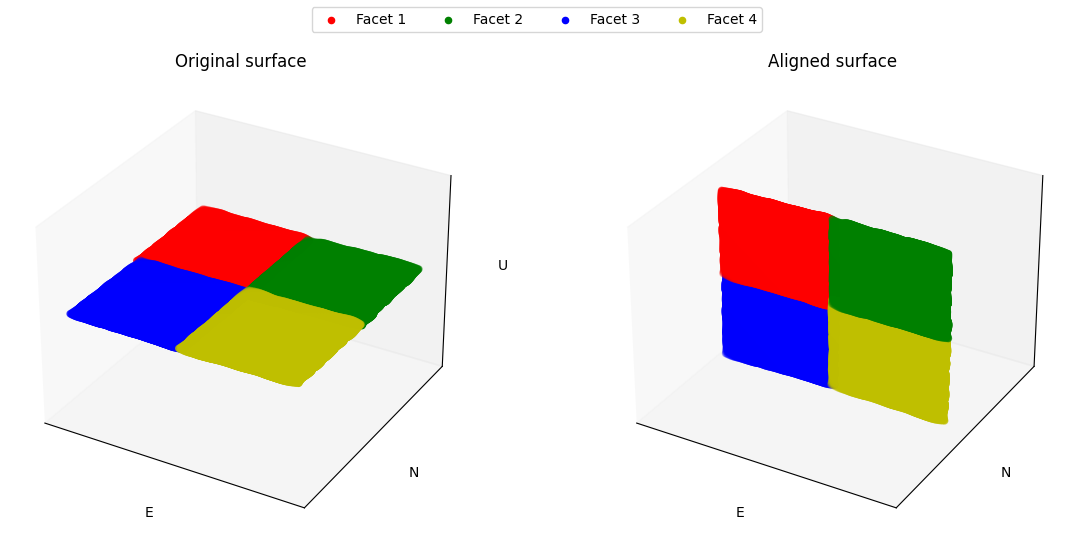

In [9]:
# Save original surface points
original_surface_points, _ = single_heliostat.surface.get_surface_points_and_normals()

# Align the heliostat
single_heliostat.set_aligned_surface(incident_ray_direction=incident_ray_direction_south)

# Define colors for each facet
colors = ['r', 'g', 'b', 'y']

# Create a 3D plot
fig = plt.figure(figsize=(14, 6))  # Adjust figure size as needed
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.3)  # Adjust width_ratios and wspace as needed

# Create subplots
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Plot each facet
for i in range(len(single_heliostat.surface.facets)):
    e_origin = original_surface_points[i, :, 0].detach().numpy()
    n_origin = original_surface_points[i, :, 1].detach().numpy()
    u_origin = original_surface_points[i, :, 2].detach().numpy()
    e_aligned = single_heliostat.current_aligned_surface_points[i, :, 0].detach().numpy()
    n_aligned = single_heliostat.current_aligned_surface_points[i, :, 1].detach().numpy()
    u_aligned = single_heliostat.current_aligned_surface_points[i, :, 2].detach().numpy()
    ax1.scatter(e_origin, n_origin, u_origin, color=colors[i], label=f'Facet {i+1}')
    ax2.scatter(e_aligned, n_aligned, u_aligned, color=colors[i], label=f'Facet {i+1}')

# Add labels
ax1.set_xlabel('E')
ax1.set_ylabel('N')
ax1.set_zlabel('U')
ax2.set_xlabel('E')
ax2.set_ylabel('N')
ax2.set_zlabel('U')
ax1.set_zlim(-0.5,0.5)
ax2.set_ylim(4.5,5.5)
ax1.set_title("Original surface")
ax2.set_title("Aligned surface")

# Remove axis numbers to create a cleaner visualization.
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])

# Create a single legend for both subplots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncols=4)


# Show the plot
plt.show()

The two plots show us the surface points on the heliostat, coded according to the facets. We see clearly:
- The original surface is pointed directly up.
- The aligned surface has been rotated 90 degrees along the North axis. This makes sense since both the receiver (aim point) and the sun are in the south, therefore, the heliostat is now orientated to reflect the sunlight back in the direction it is coming from!

Now we have our aligned our heliostat there is only one more step left - raytracing!

## Heliostat Raytracing
In this tutorial, we are considering *heliostat raytracing*. Heliostat raytracing (as it's name suggests) traces rays of sunlight from the heliostat. If we were to trace rays from the sun, then only a small portion would hit the heliostat and even a smaller portion of these rays would hit the receiver. Therefore, heliostat raytracing can be computationally efficient. Concretely, the heliostat raytracing involves three main steps:
1. We calculate the preferred reflection direction. This preferred reflection direction models the direction of a ray coming directly from the sun to the heliostat, i.e. along the incident ray direction. Specifically, we reflect this ray at every point on the heliostat to generate multipe *ideal* reflections.
2. This single ray only models an *ideal* direction, but we need to account for all possible rays coming from the sun. Therefore, we use our model of the sun to create *distortions* which we then use to slightly alter the preferred reflection directions multiple times, thus generating many realistically reflected rays.
3. We trace these rays onto the heliostat by performing a *line-plane-intersection* and determining the resulting flux density image on the receiver.

Luckily, ARTIST automatically performs all of these steps within the ``HeliostatRayTracer`` class! Therefore, raytracing with ARTIST involves two simple lines of code. First, we define the ``HeliostatRayTracer``. A ``HeliostatRayTracer`` only requires a ``Scenario`` object as an argument, but in this tutorial we additionally define the ``batch_size``. The ``batch_size`` defines the number of rays that are traced at one. 

In [10]:
raytracer = HeliostatRayTracer(
        scenario=example_scenario,batch_size=100
    )

Internally, a ``HeliostatRayTracer`` uses a ``torch.Dataset`` to generate rays and the distortion of the preferred reflection direction, line plane intersection, and calculation of the resulting flux density image can be performed in parallel if desired. However, for this tutorial we will stick to a simple sequential process &#128540;

With everything now set up, we can generate a flux density image by calling the ``trace_rays()`` function with the desired incident ray direction and finally normalizing the resulting image.

In [11]:
# Perform heliostat-based raytracing.
image_south = raytracer.trace_rays(incident_ray_direction=incident_ray_direction_south)
image_south = raytracer.normalize_bitmap(image_south)

Let's plot the image to see what ARTIST has produced!

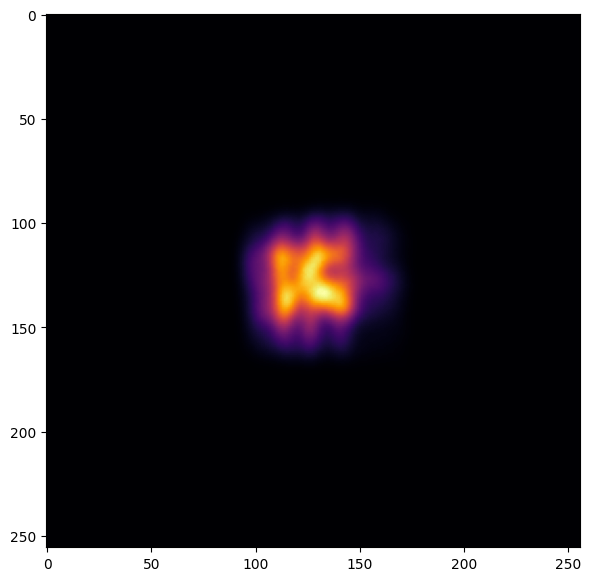

In [12]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(image_south.T.detach().numpy(), cmap='inferno')
tight_layout()

## Considering Different Light Directions
Now we have already seen how ARTIST works, but of course we can now use this scenario to explore different light directions. To simplify this, we define two functions in the following blocks:
- The first function performs the alignment and raytracing described above and returns the normalized flux density image.
- The second function takes an arbitrary number of flux density images and plots them in multiple subplots with an optional name.
Take a brief look at the functions to make sure you understand them, and then we can play around with different light directions!

In [13]:
def align_and_trace_rays(light_direction: torch.Tensor) -> torch.Tensor:
    """
    Align the heliostat and perform heliostat raytracing.
    
    Parameters
    ----------
    light_direction : torch.Tensor
        The direction of the incoming light on the heliostat.
        
    Returns
    -------
    torch.Tensor
        A tensor containing the distribution strengths used to generate the image on the receiver.
    """
    single_heliostat.set_aligned_surface(incident_ray_direction=light_direction)
    return raytracer.normalize_bitmap(raytracer.trace_rays(incident_ray_direction=light_direction))

def plot_multiple_images(*image_tensors:torch.Tensor,names: Optional[List[str]]=None) -> None:
    """
    Plot multiple receiver raytracing images in a grid.
    
    This function is flexible and able to plot an arbitrary number of images depending on the number of image tensors provided. 
    Note that the list of names must be the same length as the number of provided images, otherwise the images will be untitled.
    
    Parameters
    ----------
    image_tensors : torch.Tensor
        An arbitrary number of image tensors to be plotted.
    names : List[str], optional
        The names of the images to be plotted.
    """
    # Calculate the number of images and determine the size of the grid based on the number of images
    n = len(image_tensors)
    grid_size = math.ceil(math.sqrt(n))
    
    # Create a subplot with the appropriate size
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    
    # Flatten axes array for easy iteration if it's more than 1D
    if grid_size > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Plot each tensor
    for i, image in enumerate(image_tensors):
        ax = axes[i]
        ax.imshow(image.T.detach().numpy(), cmap='inferno')
        if names is not None and i < len(names):
            ax.set_title(names[i])
        else:
            ax.set_title(f'Untitled Image {i+1}')
    
    # Hide unused subplots
    for j in range(i + 1, grid_size * grid_size):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

Now we can use these functions to easily generate images for different incident ray directions, i.e. for when the sun is in the east, in the west, or directly above the heliostat. The following code defines those directions, generates the flux density images, and plots them.

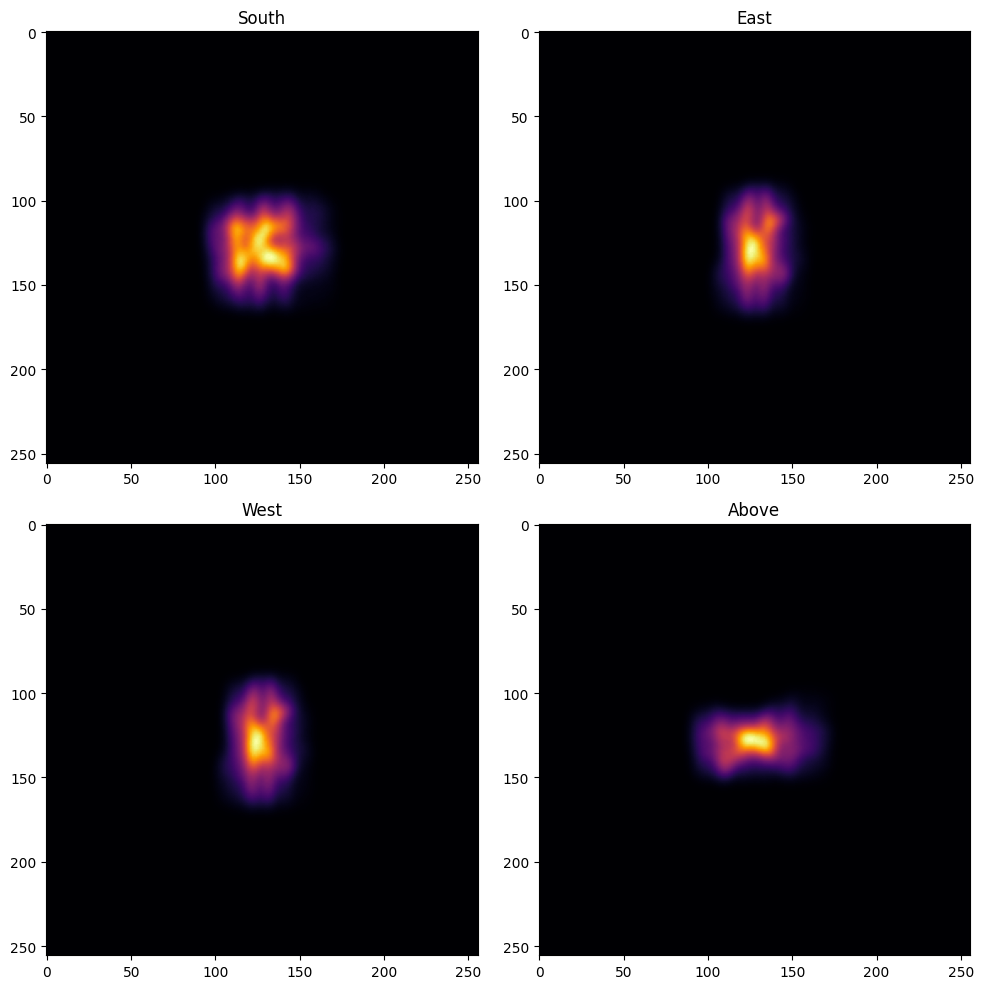

In [14]:
# Define light directions.
incident_ray_direction_east = torch.tensor([1.0, 0.0, 0.0, 0.0])
incident_ray_direction_west = torch.tensor([-1.0, 0.0, 0.0, 0.0])
incident_ray_direction_above = torch.tensor([0.0, 0.0, 1.0, 0.0])

# Perform alignment and raytracing to generate flux density images.
image_east = align_and_trace_rays(light_direction=incident_ray_direction_east)
image_west = align_and_trace_rays(light_direction=incident_ray_direction_west)
image_above = align_and_trace_rays(light_direction=incident_ray_direction_above)

# Plot the resulting images
plot_multiple_images(image_south, image_east, image_west, image_above, names=["South","East","West", "Above"])

## Experiment with ARTIST
Now you have seen the basic functionality of ARTIST feel free to experiment with different light directions by adjusting the parameter ``your_random_incident_ray_direction_here`` in the following code. Remember, if you want the plot to have a title, you also need to include a name!

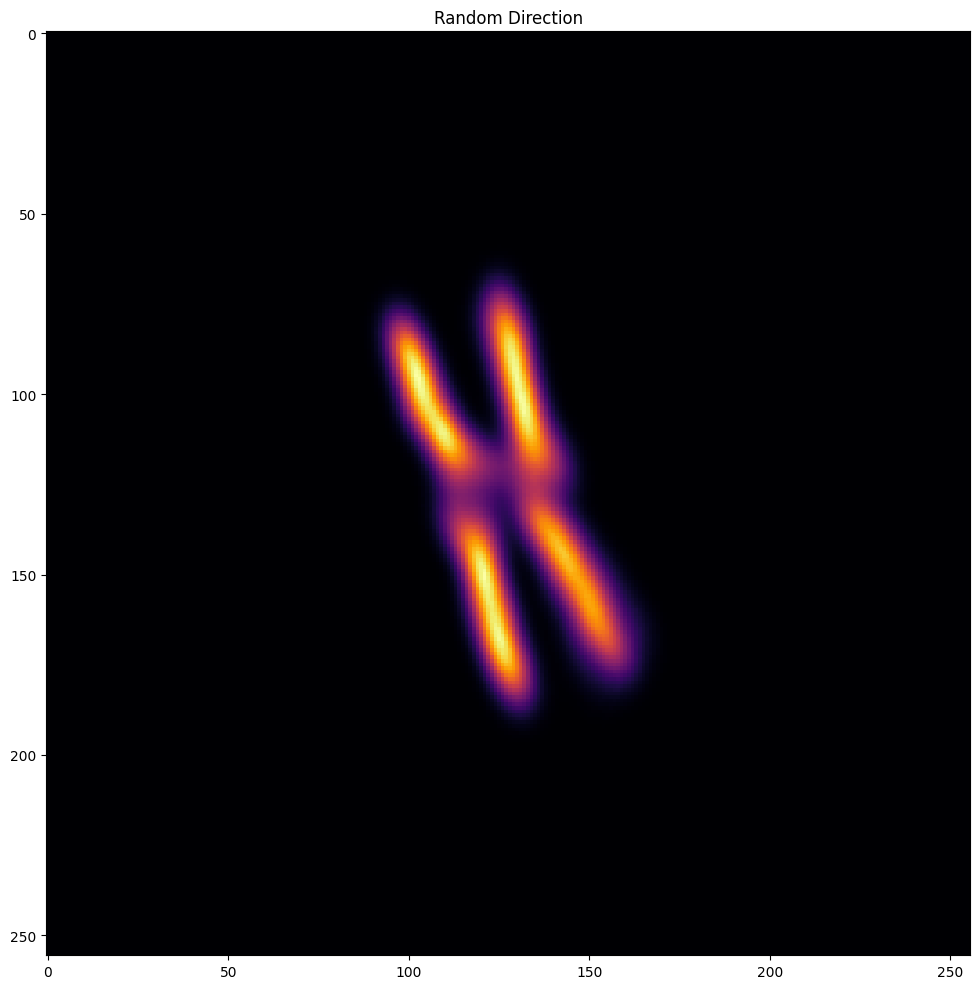

In [15]:
# Define your direction and name:
your_random_incident_ray_direction_here = torch.tensor([-4.5,34,2,0])
your_random_name_here = "Random Direction"

# Check out the results!
plot_multiple_images(align_and_trace_rays(light_direction=your_random_incident_ray_direction_here), names=[your_random_name_here])

Thanks for checking out this tutorial! We hope you enjoyed experimenting with ARTIST. If you have any feedback or questions, please don't hesitate to contact us via <artist@lists.kit.edu> &#x1f525;